In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

/home/jupyter/workspace/mytabular/.venv/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
datadir = Path('../data/atmacup5')
train_df = pd.read_csv(datadir / 'train.csv')
test_df = pd.read_csv(datadir / 'test.csv')
fitting_df = pd.read_csv(datadir / 'fitting.csv')

In [12]:
def read_fitting_data():
    return pd.read_csv(datadir / 'fitting.csv')

In [3]:
wave_data = {}

files = (datadir / 'spectrum_raw').glob('*.dat')
for p in tqdm(files):
    _df = pd.read_csv(p, sep='\t', header=None)
    x = np.zeros(shape=(512,), dtype=np.float32)
    x[:len(_df)] = _df.values[:, 1]
    wave_data[os.path.basename(p)] = x

14388it [00:22, 625.90it/s]


In [4]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())
print(fitting_df.isnull().sum())

spectrum_id          0
spectrum_filename    0
chip_id              0
exc_wl               0
layout_a             0
layout_x             0
layout_y             0
pos_x                0
target               0
dtype: int64
spectrum_id          0
spectrum_filename    0
chip_id              0
exc_wl               0
layout_a             0
layout_x             0
layout_y             0
pos_x                0
dtype: int64
spectrum_id    0
params0        0
params1        0
params2        0
params3        0
params4        0
params5        0
params6        0
rms            0
beta           0
dtype: int64


In [5]:
train_df.head()

,spectrum_id,spectrum_filename,chip_id,exc_wl,layout_a,layout_x,layout_y,pos_x,target
0,000da4633378740f1ee8,b2e223339f4abce9b400.dat,79ad4647da6de6425abf,850,2,36,140,1313.0810,0
1,000ed1a5a9fe0ad2b7dd,e2f150a503244145e7ce.dat,79ad4647da6de6425abf,780,3,0,168,159.4150,0
2,0016e3322c4ce0700f9a,3d58b7ccaee157979cf0.dat,c695a1e61e002b34e556,780,1,34,29,-610.7688,0
3,00256bd0f8c6cf5f59c8,ed3641184d3b7c0ae703.dat,c695a1e61e002b34e556,780,2,32,139,1214.6180,0
4,003483ee5ae313d37590,4c63418d39f86dfab9bb.dat,c695a1e61e002b34e556,780,0,45,85,-257.6161,0


In [6]:
train_df.columns

Index(['spectrum_id', 'spectrum_filename', 'chip_id', 'exc_wl', 'layout_a',
       'layout_x', 'layout_y', 'pos_x', 'target'],
      dtype='object')

In [7]:
fitting_df.columns

Index(['spectrum_id', 'params0', 'params1', 'params2', 'params3', 'params4',
       'params5', 'params6', 'rms', 'beta'],
      dtype='object')

In [8]:
def create_main_table_fearue(input_df):
    cols = ['exc_wl', 'layout_a', 'layout_x', 'layout_y', 'pos_x']
    return input_df[cols].copy()

In [9]:
assert len(train_df) == len(create_main_table_fearue(train_df))

In [10]:
def create_fitting_feature(input_df):
    cols = ['spectrum_id', 'params0', 'params1', 'params2', 'params3', 'params4',
       'params5', 'params6', 'rms', 'beta']

    fitting_df = read_fitting_data()
    out_df = pd.merge(input_df['spectrum_id'], fitting_df[cols], on='spectrum_id', how='left')
    out_df = out_df.drop(columns=['spectrum_id'])
    return out_df

In [13]:
assert len(train_df) == len(create_fitting_feature(train_df))
assert len(create_fitting_feature(test_df).T) == len(create_fitting_feature(train_df).T)

In [14]:
class FeatureTransformer:
    def __init__(self, processors):
        self.processors = processors

    def to_feature(self, input_df):
        out_df = pd.DataFrame()
        for func in self.processors:
            print('start {}'.format(func.__name__))
            out_df = pd.concat([out_df, func(input_df)], axis=1)
        return out_df

In [15]:
feature_transformer = FeatureTransformer(processors=[create_fitting_feature, create_main_table_fearue])

In [16]:
feat_train_df = feature_transformer.to_feature(train_df)

start create_fitting_feature
start create_main_table_fearue


In [22]:
feat_train_df

,params0,params1,params2,params3,params4,params5,params6,rms,beta,exc_wl,layout_a,layout_x,layout_y,pos_x
0,30.808589,5.811802e+02,1037.714752,1.531423,2.246965e+04,1032.317268,8.295610e+00,10.028668,2.521298e-02,850,2,36,140,1313.0810
1,91.300897,1.740582e+04,1080.510452,4.766233,3.325712e+04,1077.468855,8.018225e+00,7.948485,3.435612e-01,780,3,0,168,159.4150
2,106.642946,1.000000e-10,1119.464438,2.000000,4.257987e+04,1378.883338,1.168742e+01,10.739859,2.348528e-15,780,1,34,29,-610.7688
3,306.933674,1.099486e+04,1139.855067,5.198692,3.934974e+04,1145.212849,9.445029e+00,10.379948,2.183921e-01,780,2,32,139,1214.6180
4,46.133256,2.227622e+04,1120.918337,5.668012,3.105493e+04,1117.107782,7.658710e+00,8.316550,4.176962e-01,780,0,45,85,-257.6161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7431,117.965648,6.532486e+03,1308.737467,4.619957,1.998167e+04,1304.604584,9.733122e+00,7.705745,2.463773e-01,850,0,8,56,-1441.3620
7432,191.533462,8.261092e+01,1432.459878,0.520137,5.045881e+04,1364.248997,1.547290e+01,15.661228,1.634519e-03,850,3,12,2,543.2881
7433,-22.045684,9.999999e-11,1295.314000,2.000000,9.075595e+04,1295.527596,1.310885e+01,9.382719,1.101856e-15,780,0,41,102,-383.0251
7434,-13.162242,4.971294e+04,1435.929234,13.351986,5.000000e-13,1000.000003,3.146673e+06,6.912739,1.000000e+00,850,3,3,124,259.5428


In [17]:
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'reg_lambda': 1.,
    'n_estimators': 10000,
    'colsample_bytree': .7
}

X = feat_train_df.values
y = train_df['target'].values

In [18]:
from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(X, y))

In [23]:
from sklearn.metrics import average_precision_score
import lightgbm as lgbm

def pr_auc(y_true, y_pred):
    # 
    # y_true = data.get_label()
    score = average_precision_score(y_true, y_pred)
    return "pr_auc", score, True

def fit_lgbm(X, y, cv, params: dict=None, verbose=10):

    # パラメータがないときはからの dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv):
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)
        clf.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=100, 
                eval_metric=pr_auc,
                verbose=verbose)

        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} PR-AUC: {average_precision_score(y_valid, pred_i):.4f}')

    score = average_precision_score(y, oof_pred)
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models

In [24]:
oof, models = fit_lgbm(X, y, cv=cv, params=params)

Training until validation scores don't improve for 100 rounds
[10]	valid_0's binary_logloss: 0.0924316	valid_0's pr_auc: 0.683976
[20]	valid_0's binary_logloss: 0.07705	valid_0's pr_auc: 0.705853
[30]	valid_0's binary_logloss: 0.0696191	valid_0's pr_auc: 0.718389
[40]	valid_0's binary_logloss: 0.0657554	valid_0's pr_auc: 0.723882
[50]	valid_0's binary_logloss: 0.0624725	valid_0's pr_auc: 0.738826
[60]	valid_0's binary_logloss: 0.0615023	valid_0's pr_auc: 0.735271
[70]	valid_0's binary_logloss: 0.0610571	valid_0's pr_auc: 0.740016
[80]	valid_0's binary_logloss: 0.061082	valid_0's pr_auc: 0.736618
[90]	valid_0's binary_logloss: 0.0612196	valid_0's pr_auc: 0.738094
[100]	valid_0's binary_logloss: 0.0611007	valid_0's pr_auc: 0.742414
[110]	valid_0's binary_logloss: 0.0612896	valid_0's pr_auc: 0.743455
[120]	valid_0's binary_logloss: 0.0619178	valid_0's pr_auc: 0.740445
[130]	valid_0's binary_logloss: 0.0625785	valid_0's pr_auc: 0.73935
[140]	valid_0's binary_logloss: 0.0630003	valid_0's pr

In [25]:
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(len(order) * .4, 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    fig.tight_layout()
    return fig, ax

(<Figure size 403.2x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb9b01f0fd0>)

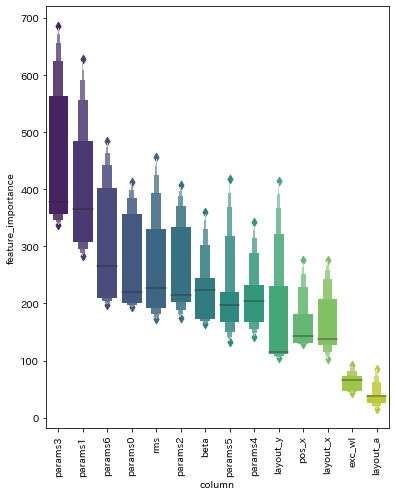

In [26]:
visualize_importance(models, feat_train_df)

In [27]:
average_precision_score(y, oof)

0.7832340904004277

In [ ]:
feat_test_df = feat_transformer.to_feature(test_df)
pred = np.array([model.predict_proba(feat_test_df.values)[:, 1] for model in models])
pred = np.mean(pred, axis=0)

sub_df = pd.DataFrame({ 'target': pred })
sub_df.to_csv('submission001.csv', index=False)